# 代码来源：https://blog.csdn.net/qq_42818403/article/details/122907583

In [11]:
import numpy as np
import sys
print(sys.executable)

import deepxde as dde

# 用于绘图
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

print(sys.executable)

D:\anaconda\python.exe
D:\anaconda\python.exe


In [12]:
#周期性边界条件
x_lower = -5
x_upper = 5
t_lower = 0
t_upper = np.pi / 2

# 创建 2D 域（用于绘图和输入）
x = np.linspace(x_lower, x_upper, 256)
t = np.linspace(t_lower, t_upper, 201)
X, T = np.meshgrid(x, t)


# 整个域变平
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# 空间和时间域/几何（对于 deepxde 模型）
space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)


In [13]:
# 损失的“物理信息”部分


def pde(x,y):
    """
    INPUTS:
        x: x[:,0] 是 x 坐标
           x[:,1] 是 t 坐标
        y: 网络输出，在这种情况下:
            y[:,0] 是 u(x,t) 实部
            y[:,1] 是 v(x,t) 虚部
    OUTPUT:
        标准形式的 pde，即必须为零的东西
    """
    
    
    u1 = y[:, 0:1]
    v1 = y[:, 1:2]
    u2 = y[:, 2:3]
    v2 = y[:, 3:4]
    

    # 在'jacobian'中，i 是输出分量，j 是输入分量
    u1_t = dde.grad.jacobian(y, x, i=0, j=1)
    v1_t = dde.grad.jacobian(y, x, i=1, j=1)
    u2_t = dde.grad.jacobian(y, x, i=2, j=1)
    v2_t = dde.grad.jacobian(y, x, i=3, j=1)

    u1_x = dde.grad.jacobian(y, x, i=0, j=0)
    v1_x = dde.grad.jacobian(y, x, i=1, j=0)
    u2_x = dde.grad.jacobian(y, x, i=2, j=0)
    v2_x = dde.grad.jacobian(y, x, i=3, j=0)

    # 在“hessian”中，i 和 j 都是输入分量。 （Hessian 原则上可以是 d^2y/dxdt、d^2y/d^2x 等）
    # 输出组件由“组件”选择
    u1_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v1_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    u2_xx = dde.grad.hessian(y, x, component=2, i=0, j=0)
    v2_xx = dde.grad.hessian(y, x, component=3, i=0, j=0)

    #f_u = u_t + 0.5 * v_xx + (u ** 2 + v ** 2) * v
    #f_v = v_t - 0.5 * u_xx - (u ** 2 + v ** 2) * u
    
    f_u1 = u1_t + v1_xx + 2*(v1 ** 2 + u1 ** 2 + 2*(v2 ** 2 + u2 ** 2)) * v1 - 2*v1*(v2 ** 2 - u2 ** 2) - 4*v2*u1*u2
    f_v1 = v1_t - u1_xx - 2*(v1 ** 2 + u1 ** 2 + 2*(v2 ** 2 + u2 ** 2)) * u1 - 2*u1*(v2 ** 2 - u2 ** 2) + 4*v1*v2*u2
    
    f_u2 = u2_t + v2_xx + 2*(v2 ** 2 + u2 ** 2 + 2*(v1 ** 2 + u1 ** 2)) * v2 - 2*v2*(v1 ** 2 - u1 ** 2) - 4*v1*u2*u1
    f_v2 = v2_t - u2_xx - 2*(v2 ** 2 + u2 ** 2 + 2*(v1 ** 2 + u1 ** 2)) * u2 - 2*u2*(v1 ** 2 - u1 ** 2) + 4*v2*v1*u1

    return [f_u1, f_v1,f_u2,f_v2]


In [14]:
# 边界条件和初始条件

# 周期性边界条件
bc_u1_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u1_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v1_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v1_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)
bc_u2_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=2
)
bc_u2_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=2
)
bc_v2_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=3
)
bc_v2_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=3
)

# 初始条件
def init_cond_u(x):
    "2 sech(x)"
    return 2 / np.cosh(x[:, 0:1])


def init_cond_v(x):
    return 0


ic_u1 = dde.IC(geomtime, init_cond_u, lambda _, on_initial: on_initial, component=0)
ic_v1 = dde.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=1)
ic_u2 = dde.IC(geomtime, init_cond_u, lambda _, on_initial: on_initial, component=2)
ic_v2 = dde.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=3)


In [15]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u1_0, bc_u1_1, bc_v1_0, bc_v1_1,bc_u2_0, bc_u2_1, bc_v2_0, bc_v2_1, ic_u1, ic_v1,ic_u2, ic_v2],
    num_domain=10000,
    num_boundary=20,
    num_initial=200,
    train_distribution="pseudo",
)

allow_unused=True
# 网络架构
net = dde.maps.FNN([2] + [100] * 4 + [4], "tanh", "Glorot normal")

model = dde.Model(data, net)


Adam 优化

In [16]:

# 强烈建议使用 GPU 加速系统.

model.compile("adam", lr=1e-3, loss="MSE")
model.train(epochs=1000, display_every=100)


Compiling model...
Building feed-forward neural network...
'build' took 0.064418 s

'compile' took 2.645161 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
0         [4.69e-02, 1.16e-02, 1.08e-02, 7.93e-02, 2.51e-01, 4.46e-04, 2.44e-01, 1.63e-04, 1.20e+00, 2.71e-07, 2.67e-02, 7.51e-04, 7.58e-01, 2.34e-02, 8.72e-01, 8.59e-03]    [4.69e-02, 1.16e-02, 1.08e-02, 7.93e-02, 2.51e-01, 4.46e-04, 2.44e-01, 1.63e-04, 1.20e+00, 2.71e-07, 2.67e-02, 7.51e-04, 7.58e-01, 2.34e-02, 8.72e-01, 8.59e-03]    []  
100       [9.65e-03, 2.71e-02, 6.82e-03, 2.87e-02, 2.66e-06, 1.27e-03, 4.33e-05, 8.57e-04, 2.03e-05, 1.10e-03, 2.41e-05, 9.65e-04, 2.23e-01, 2.18e-03, 

(<deepxde.model.LossHistory at 0x1ddaa9d1340>,
 <deepxde.model.TrainState at 0x1ddaa9d18b0>)

L-BFGS 优化

In [17]:
dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-08,
    maxiter=1000,
    maxfun=1000,
    maxls=50,
)
model.compile("L-BFGS")
model.train()


Compiling model...
'compile' took 2.094353 s

Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
1000      [1.71e-02, 4.06e-02, 1.83e-02, 4.26e-02, 1.54e-04, 2.01e-04, 1.32e-04, 3.77e-05, 3.93e-04, 3.43e-04, 2.40e-05, 2.24e-05, 8.10e-02, 2.28e-03, 8.01e-02, 2.01e-03]    [1.71e-02, 4.06e-02, 1.83e-02, 4.26e-02, 1.54e-04, 2.01e-04, 1.32e-04, 3.77e-05, 3.93e-04, 3.43e-04, 2.40e-05, 2.24e-05, 8.10e-02, 2.28e-03, 8.01e-02, 2.01e-03]    []  
2000      [1.04e-02, 9.98e-03, 1.01e-02, 1.02e-02, 5.97e-06, 1.24e-05, 3.48e-06, 3.97e-05, 4.31e-06, 4.03e-05, 4.38e-06, 3.46e-05, 2.93e-02, 3.87e-04, 2.84e-02, 4.19e-04]                                                                        

(<deepxde.model.LossHistory at 0x1ddaa9d1340>,
 <deepxde.model.TrainState at 0x1ddaa9d18b0>)

(256, 201)
(256, 201)


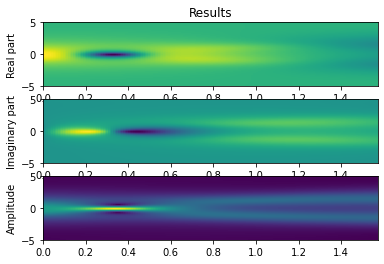

In [18]:
# 做预测
prediction = model.predict(X_star, operator=None)

u = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v = griddata(X_star, prediction[:, 1], (X, T), method="cubic")

h = np.sqrt(u ** 2 + v ** 2)

print(u.T.shape)
print(v.T.shape)


# 绘制预测
fig, ax = plt.subplots(3)

ax[0].set_title("Results")
ax[0].set_ylabel("Real part")
ax[0].imshow(
    u.T,
    interpolation="nearest", #插值
    cmap="viridis", #色彩图
    extent=[t_lower, t_upper, x_lower, x_upper], #极值
    origin="lower",
    aspect="auto",
)
ax[1].set_ylabel("Imaginary part")
ax[1].imshow(
    v.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2].set_ylabel("Amplitude")
ax[2].imshow(
    h.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)

plt.show()
